Here is a simpler example of the use of LIME for image classification by using Keras (v2 or greater)

In [1]:
# !conda install -cy anaconda keras
import os
from tensorflow import keras 
from tensorflow.keras.applications import inception_v3 as inc_net
from tensorflow.keras.preprocessing import image
import tensorflow.keras.applications.imagenet_utils as imn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import requests
from PIL import Image
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.2.4-tf


# Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [2]:
model = keras.models.load_model('0a4cad3a-7876-11ea-819e-0242ac110002.h5')

In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(32, 32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = imn.preprocess_input(x, mode="tf")
        out.append(x)
    return np.vstack(out)

def predict_func(images):
    return np.squeeze(model.predict(images))

## Let's see the top 5 prediction for some image

[0.58881927 0.41118073]


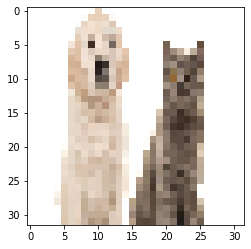

In [4]:
images = transform_img_fn(["./wolf/cd.jpeg"])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = predict_func(images)
print(preds)

## Explanation
Now let's get an explanation

In [143]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [145]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], predict_func, hide_color=0, num_samples=1000)


CPU times: user 19.8 s, sys: 1.41 s, total: 21.3 s
Wall time: 20.2 s


Image classifiers are a bit slow. Notice that an explanation on my Surface Book dGPU took 1min 29s

### Now let's see the explanation for the top class ( Black Bear)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [114]:
from skimage.segmentation import mark_boundaries

[0, 1]


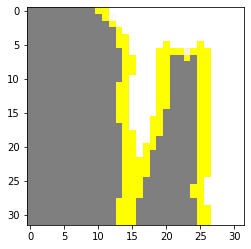

In [115]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
print(explanation.top_labels)

Or with the rest of the image present:

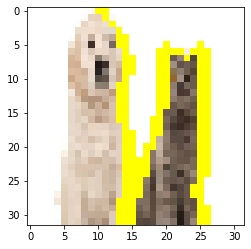

In [116]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

We can also see the 'pros and cons' (pros in green, cons in red)

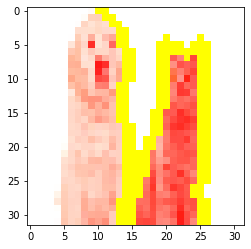

In [123]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

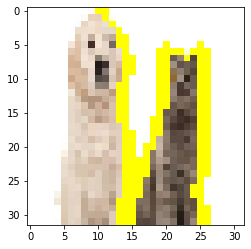

In [118]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### Let's see the explanation for the second highest prediction

Most positive towards wombat:

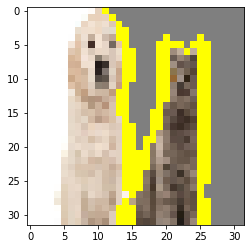

In [120]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

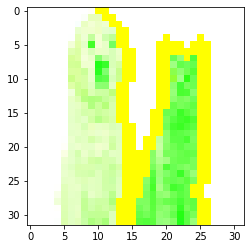

In [121]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))